In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.colors import LogNorm
import sys

# Add the path to the library folder
sys.path.append('./lib')

from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd

In [2]:
seed = 12312

In [40]:
fk_grid = np.load('Tommaso/fk_grid.npy')
data = np.load('Tommaso/data.npy')
FK = np.load('Tommaso/FK.npy')
f_bcdms = np.load('Tommaso/f_bcdms.npy')
f_bcdms = np.divide(f_bcdms, fk_grid)
data = FK @ f_bcdms
Cy = np.load('Tommaso/Cy.npy')

In [41]:
# Define GP kernel
sigma = 0.25
l0 = 1.7
delta = 1.e-9

def gibbs_fn(i1, i2):
  x1 = fk_grid[i1]
  x2 = fk_grid[i2]
  def l(x):
    return l0 * (x + delta)
  
  return sigma**2 * np.sqrt( 2 * l(x1) * l(x2) / ( np.power(l(x1),2) + np.power(l(x2),2) ) ) * np.exp(- np.power(x1 - x2, 2) / (np.power(l(x1), 2) + np.power(l(x2), 2)))

gp_kernel =  np.fromfunction(gibbs_fn, (fk_grid.size, fk_grid.size), dtype=int)

In [42]:
C_YT = FK @ gp_kernel @ FK.T + Cy
C_YT_inv = np.linalg.pinv(C_YT)
m = np.zeros(fk_grid.size)

## Vanilla version

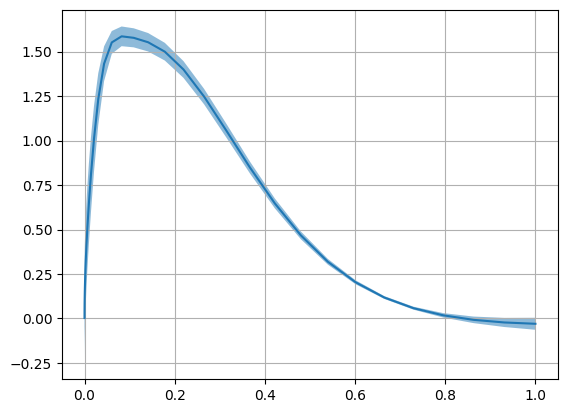

In [43]:
m_tilde = m + gp_kernel @ FK.T @ C_YT_inv @ (data - FK @ m)
K_tilde = gp_kernel - gp_kernel @ FK.T @ C_YT_inv @ FK @ gp_kernel
plt.plot(fk_grid, m_tilde)
plt.fill_between(fk_grid, m_tilde - np.sqrt(np.diag(K_tilde)), m_tilde + np.sqrt(np.diag(K_tilde)), alpha=0.5)
plt.grid()

## Rescaled kernel

In [52]:
alpha = -0.5

def gibbs_rscl_fn(i1, i2):
  x1 = fk_grid[i1]
  x2 = fk_grid[i2]
  res = np.power(x1, alpha) * np.power(x2, alpha) * gibbs_fn(i1, i2)
  return res

gp_kernel_rscl =  np.fromfunction(gibbs_rscl_fn, (fk_grid.size, fk_grid.size), dtype=int)

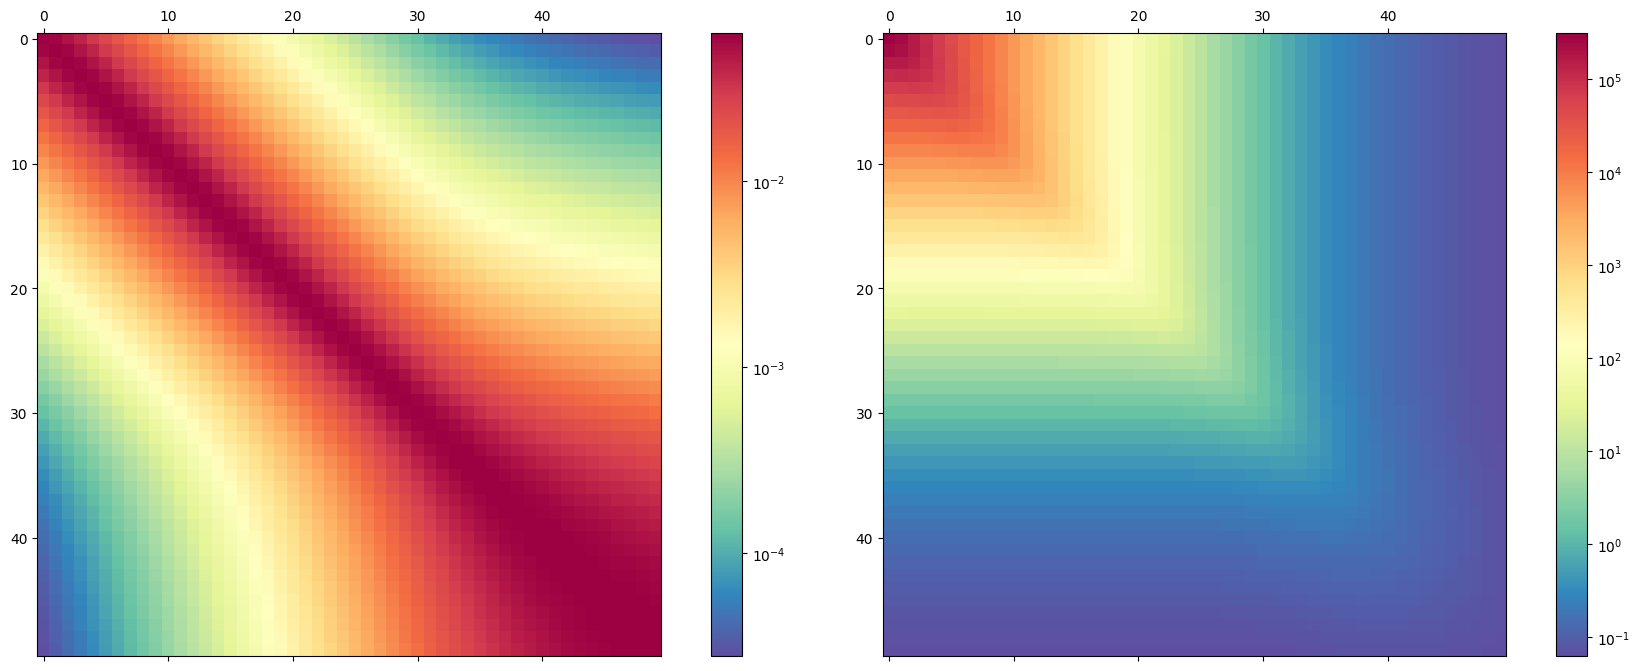

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

matrixplot = axs[0].matshow(
    gp_kernel,
    cmap=cm.Spectral_r,
    norm=mcolors.SymLogNorm(
        linthresh=0.00001, linscale=1, vmin=gp_kernel.min(), vmax=gp_kernel.max()
    ),
)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.5)
cbar = fig.colorbar(matrixplot, cax=cax)

matrixplot = axs[1].matshow(
    gp_kernel_rscl,
    cmap=cm.Spectral_r,
    norm=mcolors.SymLogNorm(
        linthresh=0.00001, linscale=1, vmin=gp_kernel_rscl.min(), vmax=gp_kernel_rscl.max()
    ),
)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.5)
cbar = fig.colorbar(matrixplot, cax=cax)

/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_78392/2615384528.py:4: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(fk_grid, m_tilde - np.sqrt(np.diag(K_tilde)), m_tilde + np.sqrt(np.diag(K_tilde)), alpha=0.5)


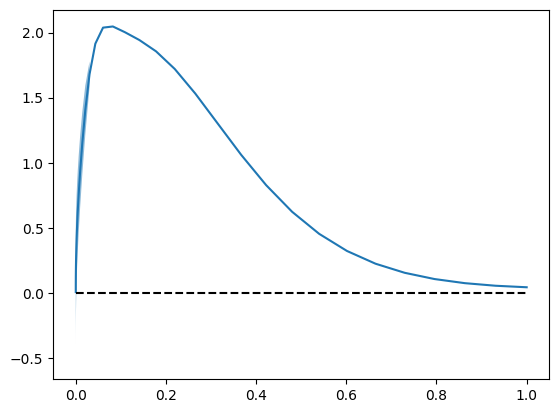

In [51]:
m_tilde = m + gp_kernel_rscl @ FK.T @ C_YT_inv @ (data - FK @ m)
K_tilde = gp_kernel_rscl - gp_kernel_rscl @ FK.T @ C_YT_inv @ FK @ gp_kernel_rscl
plt.plot(fk_grid, m_tilde)
plt.fill_between(fk_grid, m_tilde - np.sqrt(np.diag(K_tilde)), m_tilde + np.sqrt(np.diag(K_tilde)), alpha=0.5)
plt.plot(fk_grid, np.zeros_like(fk_grid), 'k--')